### Requirements

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=24c443d35ab4a220bdcb32255b420c93b33841d64132d15b693da65d17259aa2
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


### Libraries

In [2]:
from torch_geometric.datasets import Planetoid
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score

### Loading Dataset

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


### Find $S_t$ and $S_{t+1}$

In [4]:
# Define a function to compute the Dice coefficient between two nodes i and j, using the formula that you provided
def dice_coefficient(i, j, A):
    # get the set of neighbors of node i in array A
    N_i = set(np.where(A[0] == i)[0])
    # get the set of neighbors of node j in array A
    N_j = set(np.where(A[0] == j)[0])
    # compute the intersection of the two sets
    N_ij = N_i.intersection(N_j)
    # compute the Dice coefficient using the formula
    return 2 * len(N_ij) / (len(N_i) + len(N_j))

In [5]:
A = data.edge_index.numpy()
# get the number of nodes in the array
n = len(np.unique(A))
# initialize an empty numpy array of size n x n
S = np.zeros((n, n))
# loop over all pairs of nodes in the array
for i in tqdm(range(n)):
    for j in range(n):
        # compute the Dice coefficient between node i and node j
        S[i, j] = dice_coefficient(i, j, A)

T = 5
S_t = [S for _ in range(T)]



100%|██████████| 2708/2708 [03:30<00:00, 12.85it/s]


### Find Feachers of Graph

In [6]:
def get_adj_matrix(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1

    adj = torch.zeros((num_nodes, num_nodes))
    for i,j in edge_index.t():
        adj[i,j] = 1

    return adj.numpy()

In [7]:
A = torch.from_numpy(get_adj_matrix(data.edge_index)) # Adjacency matrix
S = data.x # Node feature matrix as similarity
n = S.shape[0] # Number of nodes
y = data.y # Ground-truth communities

### Creat Model

In [8]:
if n < 1000:
   d1 = n // 2
   d2 = n // 4
   d3 = n // 8
elif n < 5000:
   d1 = n // 3
   d2 = n // 5
   d3 = n // 10
else:
   d1 = n // 5
   d2 = n // 10
   d3 = n // 20

print(d1, d2, d3)

902 541 270


In [9]:
# Step 2: Create stacked autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, n, d1, d2, d3):
        super(Autoencoder, self).__init__()
        self.enc1 = nn.Linear(n, d1)
        self.enc2 = nn.Linear(d1, d2)
        self.enc3 = nn.Linear(d2, d3)
        self.dec1 = nn.Linear(d3, d2)
        self.dec2 = nn.Linear(d2, d1)
        self.dec3 = nn.Linear(d1, n)

    def encode(self, x):
        h1 = F.relu(self.enc1(x))
        h2 = F.relu(self.enc2(h1))
        h3 = F.relu(self.enc3(h2))
        return h3

    def decode(self, z):
        h3 = F.relu(self.dec1(z))
        h2 = F.relu(self.dec2(h3))
        return torch.sigmoid(self.dec3(h2))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

### Define Loss

In [10]:
# Step 4: Construct pairwise similarity matrix
O = torch.zeros((n, n))
for i in range(n):
    for j in range(n):
        if y[i] == y[j]:
           O[i][j] = 1

In [11]:
def find_reg_loss(Ht, Ht_1):
   smoothness_loss = nn.MSELoss()(Ht, Ht_1)

   return smoothness_loss

In [12]:
# Define a function to calculate the loss function
def loss_function_LSE(O, H):
    # Get the dimensions of O and H
    n = O.shape[0]
    K = H.shape[1]
    # Compute the pairwise squared Euclidean distance between rows of H
    D = torch.cdist(H, H, p=2) ** 2
    # Multiply element-wise with O and sum up all the elements
    loss = torch.sum(D * O)
    # Return the final loss value
    return loss


### Training

=========  Epoch=  1       loss=  82.18357849121094
=========  Epoch=  2       loss=  34.66196060180664
=========  Epoch=  3       loss=  17.571990966796875
=========  Epoch=  4       loss=  10.282816886901855
=========  Epoch=  5       loss=  6.569543838500977
=========  Epoch=  6       loss=  4.661598205566406
=========  Epoch=  7       loss=  3.7071497440338135
=========  Epoch=  8       loss=  3.1989290714263916
=========  Epoch=  9       loss=  2.830080032348633
=========  Epoch=  10       loss=  2.488710403442383
=========  Epoch=  11       loss=  2.168323516845703
=========  Epoch=  12       loss=  1.875434398651123
=========  Epoch=  13       loss=  1.6151846647262573
=========  Epoch=  14       loss=  1.392111897468567
=========  Epoch=  15       loss=  1.2001718282699585
=========  Epoch=  16       loss=  1.0335023403167725
=========  Epoch=  17       loss=  0.8911545276641846
=========  Epoch=  18       loss=  0.7731920480728149
=========  Epoch=  19       loss=  0.676420927

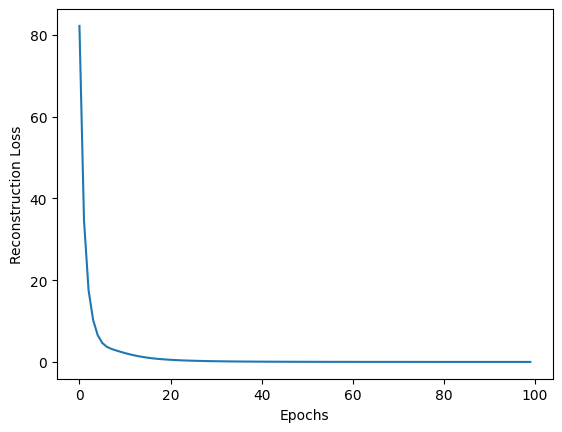

In [13]:
autoencoder = Autoencoder(n, d1, d2, d3)
opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
St =  torch.from_numpy(S_t[0])
St_1 =  torch.from_numpy(S_t[1])
St = St.type(torch.FloatTensor)
St_1 = St_1.type(torch.FloatTensor)
total_loss = []
num_epochs = 100

for epoch in range(num_epochs):

  z = autoencoder(St)
  #print(z.shape)

  # Reconstruction loss
  recon_loss = F.mse_loss(z, St)

  # Get embeddings
  Ht = autoencoder.encode(St)
  Ht_1 = autoencoder.encode(St_1)
  #print(Ht.shape)
  #print(Ht_1.shape)

  # Loss
  reg_loss = find_reg_loss(Ht, Ht_1)
  loss1 = loss_function_LSE(O, Ht)
  lambda_ = 0.1

  # Total loss
  loss = recon_loss + (1-lambda_ ) * reg_loss+ + lambda_ * loss1
  print("=========  Epoch= ",epoch+1,"      loss= ",loss.item())
  if(len(total_loss)>0):
    if(torch.abs(total_loss[len(total_loss)-1]-loss)<1e-10):
      break
  total_loss.append(loss.item())


  # Backward
  loss.backward()
  opt.step()

  # Reset gradients
  opt.zero_grad()

# Plot loss history
plt.plot(total_loss)
plt.ylabel('Reconstruction Loss')
plt.xlabel('Epochs')
plt.show()

In [14]:
torch.save(autoencoder, 'autoencoder.pth')

### Find Embedding

In [15]:
# Step 7: Extract embeddings
with torch.no_grad():
    z = autoencoder.encode(St)

### Clustring and Evaluating

In [16]:
# Step 8: Cluster with k-means
pred = KMeans(n_clusters=y.max().item()+1).fit_predict(z.numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
nmi = normalized_mutual_info_score(y, pred)
print("NMI: ", nmi)

NMI:  1.0
